# Aufgabe 1 - Akku-Abenteuer: Tobi's Optimale Routenplanung

Den Code immer nachvollziehbar kommentieren! Bitte beachtet, dass das Notebook von Anfang bis Ende ohne Fehler durchlaufen muss und dass die requirements.txt Datei aktualisiert wird. 

## Teilaufgabe a): lageplan.png laden und verarbeiten

(21, 21, 4)


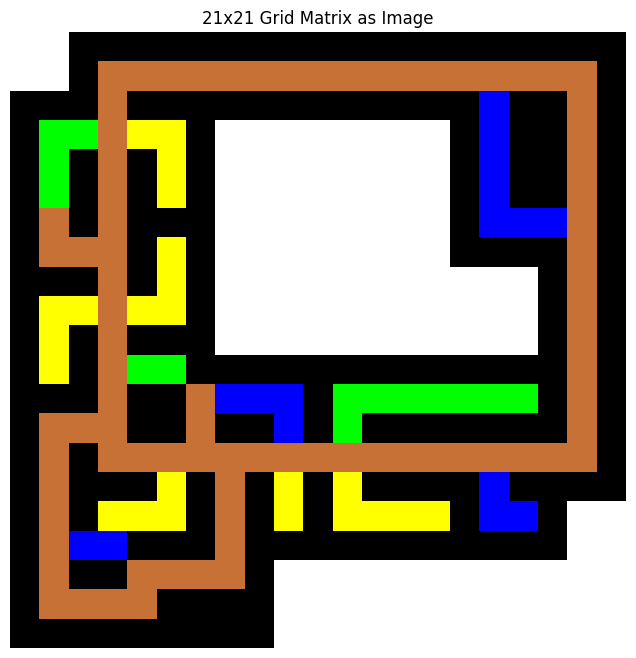

[[-1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [-1 -1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  1  0]
 [ 0  2  2  1  4  4  0 -1 -1 -1 -1 -1 -1 -1 -1  0  3  0  0  1  0]
 [ 0  2  0  1  0  4  0 -1 -1 -1 -1 -1 -1 -1 -1  0  3  0  0  1  0]
 [ 0  2  0  1  0  4  0 -1 -1 -1 -1 -1 -1 -1 -1  0  3  0  0  1  0]
 [ 0  1  0  1  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1  0  3  3  3  1  0]
 [ 0  1  1  1  0  4  0 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  1  0]
 [ 0  0  0  1  0  4  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  1  0]
 [ 0  4  4  1  4  4  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  1  0]
 [ 0  4  0  1  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  1  0]
 [ 0  4  0  1  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  1  0  0  1  3  3  3  0  2  2  2  2  2  2  2  0  1  0]
 [ 0  1  1  1  0  0  1  0  0  3  0  2  0  0  0  0  0  0  0  1  0]
 [ 0  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0]
 [ 0  1  0

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def map_color_to_value(color):
    """
    Maps an RGBA color tuple to a specific integer value representing a cell type.

    Parameters
    ----------
    color : tuple
        A tuple of 4 integers (R, G, B, A), each in the range 0-255.

    Returns
    -------
    int
        An integer code for the cell type:
        - 0: black (wall)
        - -1: white (outside)
        - 2: green (office)
        - 3: blue (kitchen)
        - 4: yellow (laboratory)
        - 1: brown (hallway)
    """
    # For RGBA colors
    r, g, b, a = color

    # Define thresholds and mappings
    # Check for black (all values close to 0)
    if r <= 30 and g <= 30 and b <= 30:
        return 0

    # Check for white
    elif r >= 220 and g >= 220 and b >= 220:
        return -1

    # Check for green
    elif r <= 50 and g >= 200 and b <= 50:
        return 2

    # Check for blue
    elif r <= 50 and g <= 50 and b >= 200:
        return 3
    
    # Check for yellow
    elif r >= 200 and g >= 200 and b <= 50:
        return 4

    # Check for Brown
    else:
        return 1


# Load the image
img = np.array(Image.open('lageplan.png'))

# Calculate the cell size
cell_size = 420 // 21  # = 20 pixels

# Create an empty 21x21 matrix
matrix = np.zeros((21, 21, 4), dtype=np.uint8)

# Sample the center pixel of each cell
for i in range(21):
    for j in range(21):
        # Calculate center coordinates
        center_y = i * cell_size + cell_size // 2
        center_x = j * cell_size + cell_size // 2
        
        # Get color at center
        matrix[i, j] = img[center_y, center_x]

# Print or use the matrix
print(matrix.shape)  # Should be (21, 21, 4) for RGBA

matrix_image = Image.fromarray(matrix)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(matrix_image)
plt.title("21x21 Grid Matrix as Image")
plt.axis('off')  
plt.show()

# Map Matrix to custom values instead of color vectors
mapped_matrix = np.zeros((21, 21), dtype=int)

for i in range(21):
    for j in range(21):
        mapped_matrix[i, j] = map_color_to_value(matrix[i, j])

# 3. Print the mapped matrix
print(mapped_matrix)


## Teilaufgabe b): Breitensuche

In [22]:
def visualize_path(matrix, path, explored, algorithm_name, total_cost=None):
    """
    Visualizes the matrix, explored nodes, and the found path.
    
    Parameters:
    ----------
    matrix : numpy.ndarray
        The grid matrix
    path : list
        List of positions in the path
    explored : set
        Set of explored positions
    algorithm_name : str
        Name of the algorithm to display in the title
    total_cost : int, optional
        Total cost of the path
    """
    # Create a figure with a specific size and get the axes
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Create a custom colormap
    cmap = plt.cm.colors.ListedColormap(['white', 'black', 'brown', 'green', 'blue', 'yellow'])
    bounds = [-1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    # Plot the matrix on the specified axes
    im = ax.imshow(matrix, cmap=cmap, norm=norm)
    
    # Set ticks at every integer position
    ax.set_xticks(np.arange(0, matrix.shape[1], 1))
    ax.set_yticks(np.arange(0, matrix.shape[0], 1))
    
    # Add grid lines offset by 0.5 in both directions
    ax.set_xticks(np.arange(-0.5, matrix.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, matrix.shape[0], 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=1)
    ax.grid(which='major', visible=False)  # Hide major grid
    
    # Plot explored nodes
    for node in explored:
        if node not in path:  # Don't plot nodes in the path
            ax.plot(node[1], node[0], 'o', color='lightgray', markersize=5, alpha=0.5)
    
    # Plot the path
    if path:
        path_y = [node[0] for node in path]
        path_x = [node[1] for node in path]
        ax.plot(path_x, path_y, '-o', color='red', linewidth=2, markersize=6)
        
        # Mark start and goal
        ax.plot(path[0][1], path[0][0], 'D', color='yellow', markersize=10)
        ax.plot(path[-1][1], path[-1][0], '*', color='yellow', markersize=12)
    
    # Set title with algorithm name and cost if provided
    if total_cost is not None:
        ax.set_title(f"{algorithm_name} Path Finding (Steps: {len(path)-1 if path else 'No path'}, Cost: {total_cost})")
    else:
        ax.set_title(f"{algorithm_name} Path Finding (Steps: {len(path)-1 if path else 'No path found'})")
    
    plt.show()

Start position value: (17, 3)
Goal position value: (3, 1)
Path found: True
Number of steps: 20
Number of explored nodes: 101


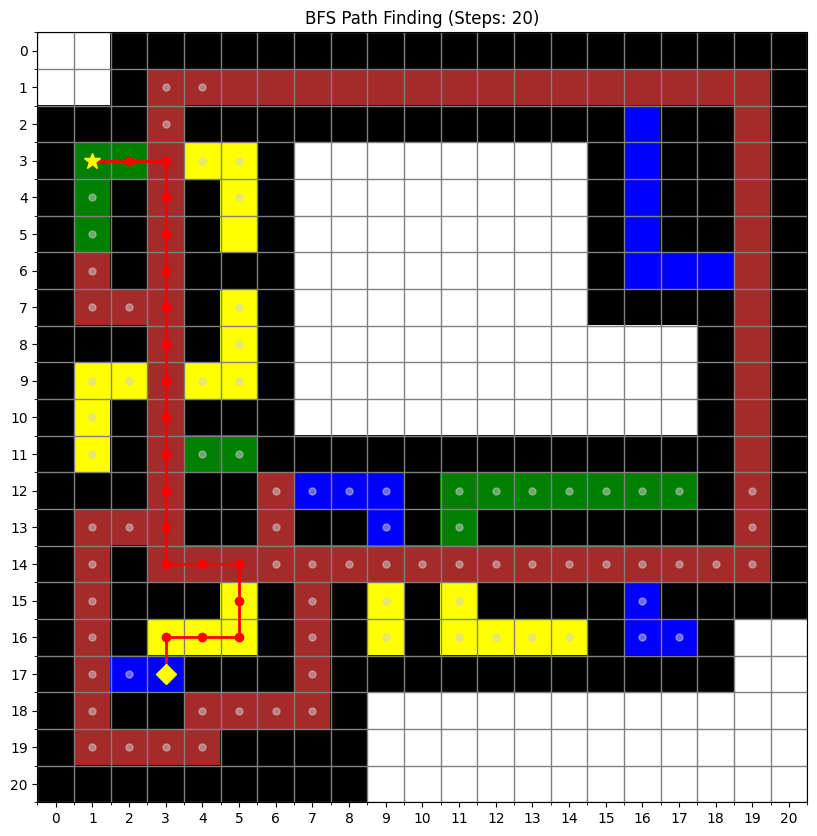

In [24]:
# Implement Breadth-First Search algorithm for pathfinding
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

def breadth_first_search(matrix, start, goal):
    """
    Performs BFS to find the shortest path from start to goal in the matrix.
    
    Parameters:
    ----------
    matrix : numpy.ndarray
        The grid representation where:
        - 0: wall (not traversable)
        - -1: outside (not traversable)
        - 1: hallway (traversable)
        - 2: office (traversable)
        - 3: kitchen (traversable)
    start : tuple
        Starting position (row, col)
    goal : tuple
        Goal position (row, col)
        
    Returns:
    -------
    tuple
        (path, explored_nodes, steps_count)
        where path is a list of positions from start to goal,
        explored_nodes is a set of all visited positions,
        steps_count is the number of steps in the final path
    """
    # Print the values at start and goal positions for debugging
    print(f"Start position value: {start_pos}")
    print(f"Goal position value: {goal_pos}")
    
    # Check if start or goal positions are valid (> 0 means traversable)
    if matrix[start] <= 0 or matrix[goal] <= 0:
        print("Start or goal position is not traversable!")
        return None, set(), 0
    
    # Initialize data structures
    queue = deque([start])
    explored = set([start])
    parent = {start: None}
    
    # Define possible movements (up, right, down, left)
    movements = [(-1, 0), (0, 1), (1, 0), (0, -1)]
    
    # BFS main loop
    while queue:
        current = queue.popleft()
        
        # Check if goal is reached
        if current == goal:
            # Reconstruct path
            path = []
            while current is not None:
                path.append(current)
                current = parent[current]
            path.reverse()  # Path from start to goal
            return path, explored, len(path) - 1
        
        # Explore neighbors
        for dr, dc in movements:
            r, c = current[0] + dr, current[1] + dc
            
            # Check if position is within bounds and not a wall or outside
            if (0 <= r < matrix.shape[0] and 
                0 <= c < matrix.shape[1] and 
                matrix[r, c] > 0 and 
                (r, c) not in explored):
                
                queue.append((r, c))
                explored.add((r, c))
                parent[(r, c)] = current
    
    # No path found
    print("BFS completed without finding a path")
    return None, explored, 0

# Run BFS algorithm
start_pos = (17, 3)  # Given start position
goal_pos = (3, 1)    # Given goal position

path, explored, steps = breadth_first_search(mapped_matrix, start_pos, goal_pos)

# Print results
print(f"Path found: {path is not None}")
print(f"Number of steps: {steps}")
print(f"Number of explored nodes: {len(explored)}")

# Visualize the result
visualize_path(mapped_matrix, path, explored, "BFS")


## Teilaufgabe c): A*-Algorithmus

Start position value: (17, 3)
Goal position value: (3, 1)
Path found: True
Total cost: 45
Number of steps: 20
Number of explored nodes: 54


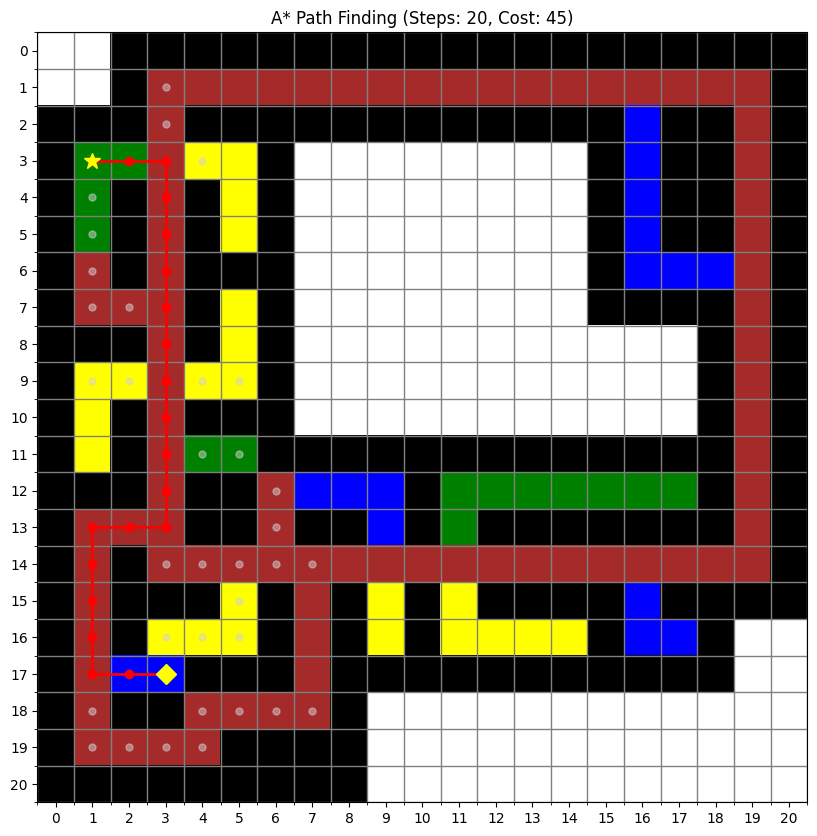

In [26]:
import heapq
import numpy as np
import matplotlib.pyplot as plt

def manhattan_distance(a, b):
    """
    Calculate Manhattan distance between two points.
    
    Parameters:
    ----------
    a : tuple
        First point (row, col)
    b : tuple
        Second point (row, col)
        
    Returns:
    -------
    int
        Manhattan distance between a and b
    """
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def get_terrain_cost(matrix, pos):
    """
    Get the cost of moving through a specific terrain type.
    
    Parameters:
    ----------
    matrix : numpy.ndarray
        The grid representation
    pos : tuple
        Position (row, col)
        
    Returns:
    -------
    int
        Cost of traversing this terrain:
        - 1 (hallway): 2
        - 2 (office): 4
        - 3 (kitchen): 3
        - 4 (laboratory): 5
    """
    terrain_type = matrix[pos]
    
    if terrain_type == 1:  # hallway
        return 2
    elif terrain_type == 2:  # office
        return 4
    elif terrain_type == 3:  # kitchen
        return 3
    elif terrain_type == 4:  # laboratory
        return 5
    else:
        return float('inf')  # Walls and outside are not traversable

def astar_search(matrix, start, goal):
    """
    Performs A* search to find the lowest cost path from start to goal in the matrix.
    
    Parameters:
    ----------
    matrix : numpy.ndarray
        The grid representation where:
        - 0: wall (not traversable)
        - -1: outside (not traversable)
        - 1: hallway (cost: 2)
        - 2: office (cost: 4)
        - 3: kitchen (cost: 3)
        - 4: laboratory (cost: 5)
    start : tuple
        Starting position (row, col)
    goal : tuple
        Goal position (row, col)
        
    Returns:
    -------
    tuple
        (path, explored_nodes, total_cost)
        where path is a list of positions from start to goal,
        explored_nodes is a set of all visited positions,
        total_cost is the total cost of the path
    """
    # Print the values at start and goal positions for debugging
    print(f"Start position value: {start_pos}")
    print(f"Goal position value: {goal_pos}")
    
    # Check if start or goal positions are valid (> 0 means traversable)
    if matrix[start] <= 0 or matrix[goal] <= 0:
        print("Start or goal position is not traversable!")
        return None, set(), 0
    
    # Initialize data structures
    # Priority queue for open nodes: (f_score, tiebreaker, node)
    open_set = []
    counter = 0  # Tiebreaker for nodes with same f_score
    heapq.heappush(open_set, (0, counter, start))
    
    # Nodes already evaluated
    closed_set = set()
    
    # For node n, came_from[n] is the node immediately preceding it on the cheapest path
    came_from = {start: None}
    
    # For node n, g_score[n] is the cost of the cheapest path from start to n currently known
    g_score = {start: 0}
    
    # For node n, f_score[n] = g_score[n] + h(n)
    f_score = {start: manhattan_distance(start, goal)}
    
    # Define possible movements (up, right, down, left)
    movements = [(-1, 0), (0, 1), (1, 0), (0, -1)]
    
    # A* main loop
    while open_set:
        # Get the node with the lowest f_score
        _, _, current = heapq.heappop(open_set)
        
        # Check if goal is reached
        if current == goal:
            # Reconstruct path
            path = []
            total_cost = g_score[current]
            while current is not None:
                path.append(current)
                current = came_from[current]
            path.reverse()  # Path from start to goal
            return path, closed_set, total_cost
        
        # Add current to closed set
        closed_set.add(current)
        
        # Explore neighbors
        for dr, dc in movements:
            r, c = current[0] + dr, current[1] + dc
            neighbor = (r, c)
            
            # Check if position is within bounds and not a wall or outside
            if (0 <= r < matrix.shape[0] and 
                0 <= c < matrix.shape[1] and 
                matrix[r, c] > 0 and 
                neighbor not in closed_set):
                
                # Calculate tentative g_score with terrain cost
                terrain_cost = get_terrain_cost(matrix, neighbor)
                tentative_g_score = g_score[current] + terrain_cost
                
                # If neighbor not in open set or better path found
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    # Record this path
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = g_score[neighbor] + manhattan_distance(neighbor, goal)
                    
                    # Add to open set with updated priority
                    counter += 1
                    heapq.heappush(open_set, (f_score[neighbor], counter, neighbor))
    
    # No path found
    print("A* completed without finding a path")
    return None, closed_set, 0

# Run A* algorithm
start_pos = (17, 3)  # Given start position
goal_pos = (3, 1)    # Given goal position

path_astar, explored_astar, total_cost = astar_search(mapped_matrix, start_pos, goal_pos)

# Print results
print(f"Path found: {path_astar is not None}")
print(f"Total cost: {total_cost}")
print(f"Number of steps: {len(path_astar) - 1 if path_astar else 0}")
print(f"Number of explored nodes: {len(explored_astar)}")

# Visualize the result
visualize_path(mapped_matrix, path_astar, explored_astar, "A*", total_cost)

## Teilaufgabe d): Greedy Best First Search-Algorithmus

Start position value: 3
Goal position value: 2
Path found: True
Total cost: 45
Number of steps: 20
Number of explored nodes: 21


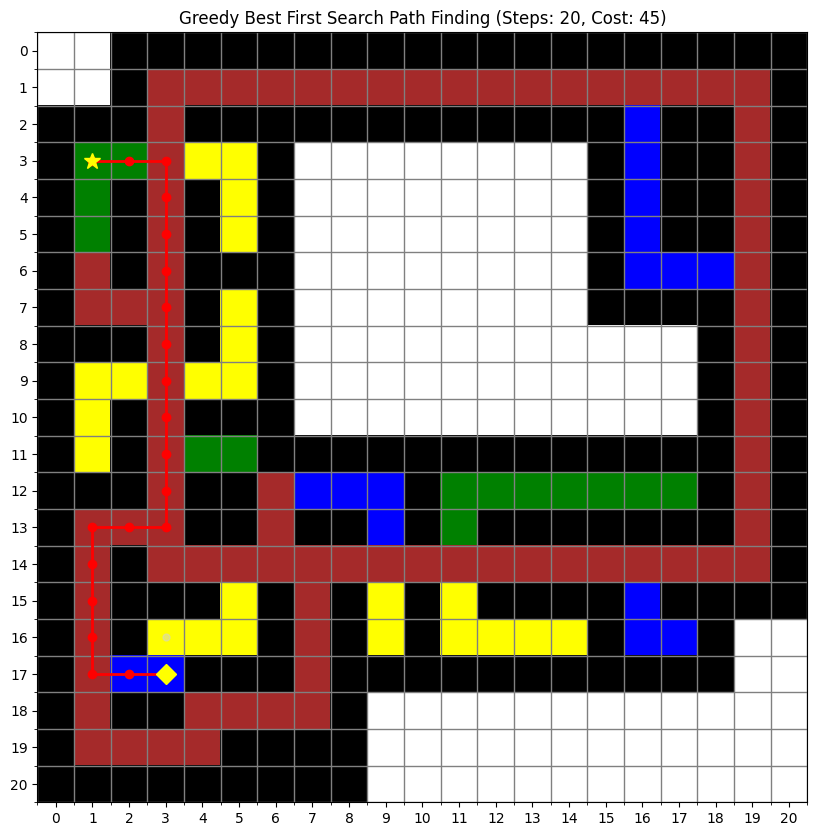

In [27]:
# Implement Greedy Best First Search algorithm for pathfinding
import heapq
import numpy as np
import matplotlib.pyplot as plt

def greedy_best_first_search(matrix, start, goal):
    """
    Performs Greedy Best First Search to find a path from start to goal in the matrix.
    Uses Manhattan distance as heuristic.
    
    Parameters:
    ----------
    matrix : numpy.ndarray
        The grid representation where:
        - 0: wall (not traversable)
        - -1: outside (not traversable)
        - 1: hallway (traversable)
        - 2: office (traversable)
        - 3: kitchen (traversable)
        - 4: laboratory (traversable)
    start : tuple
        Starting position (row, col)
    goal : tuple
        Goal position (row, col)
        
    Returns:
    -------
    tuple
        (path, explored_nodes, total_cost)
        where path is a list of positions from start to goal,
        explored_nodes is a set of all visited positions,
        total_cost is the total cost of the path
    """
    # Print the values at start and goal positions for debugging
    print(f"Start position value: {matrix[start]}")
    print(f"Goal position value: {matrix[goal]}")
    
    # Check if start or goal positions are valid (> 0 means traversable)
    if matrix[start] <= 0 or matrix[goal] <= 0:
        print("Start or goal position is not traversable!")
        return None, set(), 0
    
    # Initialize data structures
    # Priority queue for open nodes: (heuristic, tiebreaker, node)
    open_set = []
    counter = 0  # Tiebreaker for nodes with same heuristic value
    
    # Use Manhattan distance as heuristic
    initial_h = manhattan_distance(start, goal)
    heapq.heappush(open_set, (initial_h, counter, start))
    
    # Nodes already evaluated
    closed_set = set()
    
    # For node n, came_from[n] is the node immediately preceding it
    came_from = {start: None}
    
    # For calculating total cost of the final path
    g_score = {start: 0}
    
    # Define possible movements (up, right, down, left)
    movements = [(-1, 0), (0, 1), (1, 0), (0, -1)]
    
    # Greedy BFS main loop
    while open_set:
        # Get the node with the lowest heuristic value
        _, _, current = heapq.heappop(open_set)
        
        # Check if goal is reached
        if current == goal:
            # Reconstruct path
            path = []
            node = current
            total_cost = 0
            
            # Calculate total cost and build path
            while node is not None:
                path.append(node)
                # If not at start, add terrain cost
                if node != start:
                    total_cost += get_terrain_cost(matrix, node)
                node = came_from[node]
                
            path.reverse()  # Path from start to goal
            return path, closed_set, total_cost
        
        # Add current to closed set
        closed_set.add(current)
        
        # Explore neighbors
        for dr, dc in movements:
            r, c = current[0] + dr, current[1] + dc
            neighbor = (r, c)
            
            # Check if position is within bounds and not a wall or outside
            if (0 <= r < matrix.shape[0] and 
                0 <= c < matrix.shape[1] and 
                matrix[r, c] > 0 and 
                neighbor not in closed_set):
                
                # If neighbor not already in open set, add it
                if neighbor not in came_from:
                    # Record parent for path reconstruction
                    came_from[neighbor] = current
                    
                    # Calculate terrain cost for result statistics
                    terrain_cost = get_terrain_cost(matrix, neighbor)
                    g_score[neighbor] = g_score[current] + terrain_cost
                    
                    # Use only heuristic for priority
                    h_score = manhattan_distance(neighbor, goal)
                    
                    # Add to open set with heuristic priority
                    counter += 1
                    heapq.heappush(open_set, (h_score, counter, neighbor))
    
    # No path found
    print("Greedy Best First Search completed without finding a path")
    return None, closed_set, 0

# Run Greedy Best First Search algorithm
start_pos = (17, 3)  # Given start position
goal_pos = (3, 1)    # Given goal position

path_greedy, explored_greedy, total_cost_greedy = greedy_best_first_search(mapped_matrix, start_pos, goal_pos)

# Print results
print(f"Path found: {path_greedy is not None}")
print(f"Total cost: {total_cost_greedy}")
print(f"Number of steps: {len(path_greedy) - 1 if path_greedy else 0}")
print(f"Number of explored nodes: {len(explored_greedy)}")

# Visualize the result
visualize_path(mapped_matrix, path_greedy, explored_greedy, "Greedy Best First Search", total_cost_greedy)

## Teilaufgabe e): Dusseliger Doktorand

Modified matrix with blocked hallway:
[[-1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [-1 -1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  1  0]
 [ 0  2  2  1  4  4  0 -1 -1 -1 -1 -1 -1 -1 -1  0  3  0  0  1  0]
 [ 0  2  0 -1  0  4  0 -1 -1 -1 -1 -1 -1 -1 -1  0  3  0  0  1  0]
 [ 0  2  0 -1  0  4  0 -1 -1 -1 -1 -1 -1 -1 -1  0  3  0  0  1  0]
 [ 0  1  0 -1  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1  0  3  3  3  1  0]
 [ 0  1  1 -1  0  4  0 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  1  0]
 [ 0  0  0 -1  0  4  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  1  0]
 [ 0  4  4 -1  4  4  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  1  0]
 [ 0  4  0 -1  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  1  0]
 [ 0  4  0 -1  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0 -1  0  0  1  3  3  3  0  2  2  2  2  2  2  2  0  1  0]
 [ 0  1  1 -1  0  0  1  0  0  3  0  2  0  0  0  0  0  0  0  1  0]
 [ 0  1  0 -1  1  1  1  1  1  1  1  1 

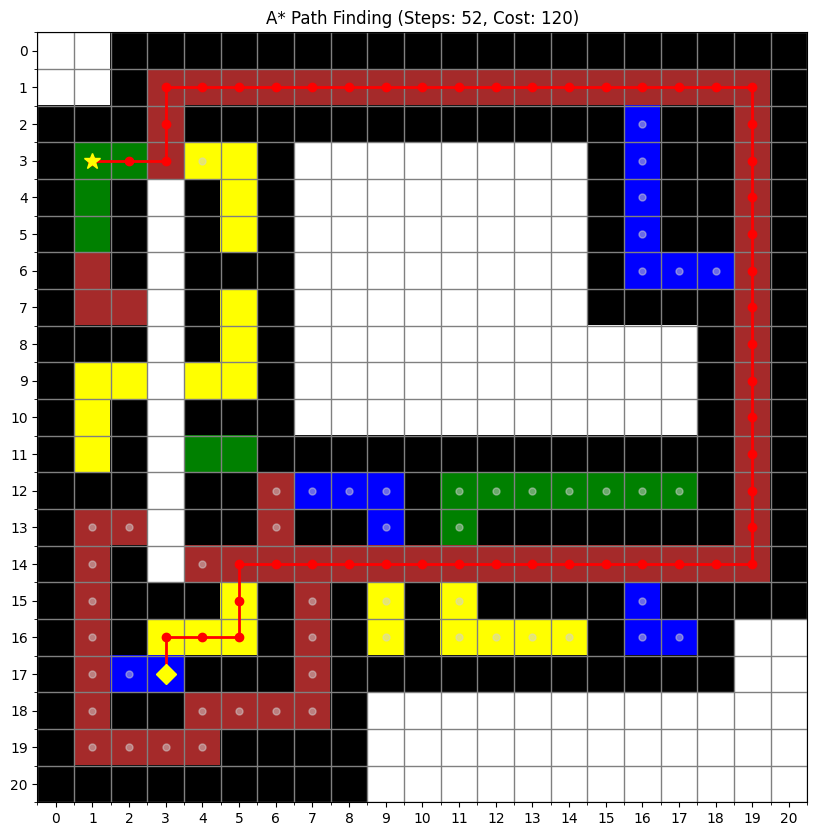

Start position value: 3
Goal position value: 2
Path found: True
Total cost: 127
Number of steps: 52
Number of explored nodes: 99


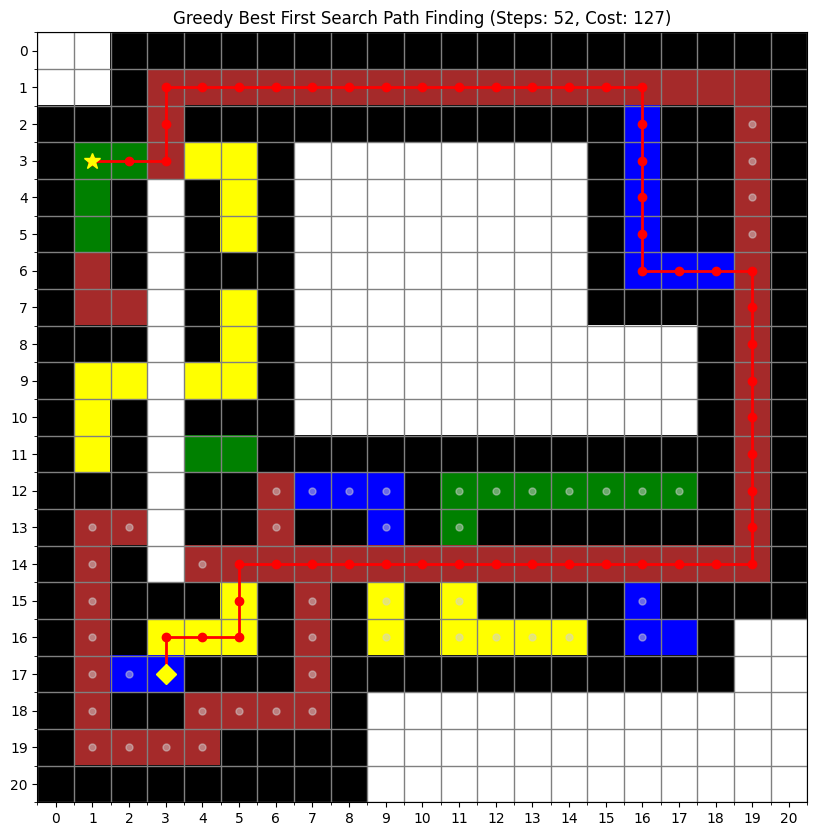

In [40]:
# Modify the matrix to make the floor from (3,3) to (14,3) not traversable
modified_matrix = mapped_matrix.copy()

# Set cells from (4,3) to (14,3) as walls NOTE: I'm assuming you don't mean from (3,3) because otherwise the goal would not be accessible
for i in range(4, 15):
    modified_matrix[i, 3] = -1

print("Modified matrix with blocked hallway:")
print(modified_matrix)

# Run A* algorithm
start_pos = (17, 3)  # Given start position
goal_pos = (3, 1)    # Given goal position

path_astar, explored_astar, total_cost = astar_search(modified_matrix, start_pos, goal_pos)

# Print results
print(f"Path found: {path_astar is not None}")
print(f"Total cost: {total_cost}")
print(f"Number of steps: {len(path_astar) - 1 if path_astar else 0}")
print(f"Number of explored nodes: {len(explored_astar)}")

# Visualize the result
visualize_path(modified_matrix, path_astar, explored_astar, "A*", total_cost)

# Run Greedy Best First Search algorithm
start_pos = (17, 3)  # Given start position
goal_pos = (3, 1)    # Given goal position

path_greedy, explored_greedy, total_cost_greedy = greedy_best_first_search(modified_matrix, start_pos, goal_pos)

# Print results
print(f"Path found: {path_greedy is not None}")
print(f"Total cost: {total_cost_greedy}")
print(f"Number of steps: {len(path_greedy) - 1 if path_greedy else 0}")
print(f"Number of explored nodes: {len(explored_greedy)}")

# Visualize the result
visualize_path(modified_matrix, path_greedy, explored_greedy, "Greedy Best First Search", total_cost_greedy)